## Create a landmask for SeaWIFS climatology

Author: Frank Bryan (bryan@ucar.edu ) 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
## Get the land/water mask
path_in = '../ncfiles/'
file_in = 'LandWater15ARC.nc'
ds_hires = xr.open_dataset(path_in+file_in)
ds_hires

<xarray.Dataset>
Dimensions:    (lat: 43200, lon: 86400)
Coordinates:
  * lat        (lat) float32 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 90.0
  * lon        (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    LandWater  (lat, lon) float32 ...
Attributes: (12/24)
    title:                      Land Water Mask
    description:                15 arcsecond resolution, 7 category land wate...
    Conventions:                CF-1.6
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    license:                    http://science.nasa.gov/earth-science/earth-s...
    date_created:               2015-06-26T09:00:00Z
    ...                         ...
    node_offset:                1
    cdm_data_type:              grid
    references:                 Carroll, M. L., Townshend, J. R., DiMiceli, C...
    history:                    Extracted from MODIS Collection 6 dem15ARC La...
    comment:                    Shallow_Ocean = Ocean <5k from coast OR <50m ...
    _lastModified:              2016-08-29T21:27:29Z

In [3]:
## Get some SeaWIFS data (only need the coordinates)
path_chl = '../ncfiles/'
file_chl = 'S19972442010273.L3m_MC_CHL_chlor_a_9km.nc'
ds_chl = xr.open_dataset(path_chl+file_chl)
ds_chl

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon      (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (lat, lon) float32 ...
    palette  (rgb, eightbitcolor) uint8 ...
Attributes: (12/64)
    product_name:                      S19972442010273.L3m_MC_CHL_chlor_a_9km.nc
    instrument:                        SeaWiFS
    title:                             SeaWiFS Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Orbview-2
    temporal_range:                    13-year
    ...                                ...
    identifier_product_doi:            10.5067/ORBVIEW-2/SEAWIFS/L3M/CHL/2018
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         5045203
    data_minimum:                      0.01922724
    data_maximum:                      99.64571

In [4]:
## Subsample the 15 arcsecond (1/240 deg) mask grid to the 1/12 deg SeaWIFS grid (approx)
Mask_lores = ds_hires['LandWater'].sel(
                lon=ds_chl['lon'],
                lat=ds_chl['lat'],method='nearest').astype('int')

In [5]:
## Create a corresponding mask of all ocean areas (shallow=0,shelf=6,deep=7)
Ocean_lores = xr.where(Mask_lores==0,1,0)
Ocean_lores = xr.where(Mask_lores>=6,1,Ocean_lores)
Ocean_lores = Ocean_lores.astype('int')

## Create the reciprocal land mask
Land_lores = (1 - Ocean_lores).astype('int')

In [6]:
# Put the masks in a dataset
ds_out = xr.Dataset({"LandWater" : Mask_lores})

ds_out['Ocean'] = Ocean_lores
ds_out['Ocean'].attrs['long_name'] = 'Ocean Mask'
ds_out['Ocean'].attrs['flag_values'] = '0, 1'
ds_out['Ocean'].attrs['flag_meanings'] = '0=Land or Inland Water, 1=Ocean'

ds_out['Land'] = Land_lores
ds_out['Land'].attrs['long_name'] = 'Land Mask'
ds_out['Land'].attrs['flag_values'] = '0, 1'
ds_out['Land'].attrs['flag_meanings'] = '1=Land or Inland Water, 0=Ocean'

In [7]:
# Tweak the coordinates to agree exactly with SeaWIFS 
ds_out.coords['lon'] = ds_chl['lon']
ds_out.coords['lat'] = ds_chl['lat']

In [8]:
# Add a history attribute
from datetime import date
today = date.today()
dstr = today.strftime("%Y-%m-%d")
astr = 'Created ' + dstr + ' from input file ' + path_in+file_in
astr
ds_out.attrs['history'] = astr

In [9]:
ds_out

<xarray.Dataset>
Dimensions:    (lat: 2160, lon: 4320)
Coordinates:
  * lat        (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon        (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Data variables:
    LandWater  (lat, lon) int64 7 7 7 7 7 7 7 7 7 7 7 ... 1 1 1 1 1 1 1 1 1 1 1
    Ocean      (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0
    Land       (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
Attributes:
    history:  Created 2022-05-06 from input file ../ncfiles/LandWater15ARC.nc

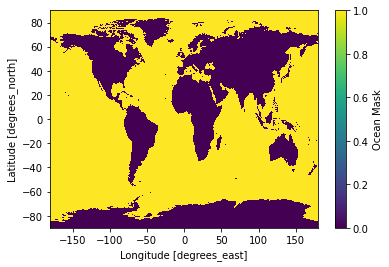

In [10]:
ds_out['Ocean'].plot(robust=True)

In [11]:
fileout = '../ncfiles/LandWater_SeaWIFS.nc'
ds_out.to_netcdf(path=fileout)f1tv